In [2]:
!pip install torchsummary

In [3]:
#!/usr/bin/env python3
import os.path
import torch
import helper
import warnings
from distutils.version import LooseVersion
from PIL import Image
import numpy as np
import torchvision.models as models
from torchsummary import summary
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F
from glob import glob
import math
import re
import sys
import random
from matplotlib import pyplot as plt
import torchvision
from torchvision.utils import make_grid
import cv2
from skimage import io, transform
import scipy.misc

In [4]:
# Check for a GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if not torch.cuda.is_available():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(torch.cuda.get_device_name(0)))


Default GPU Device: Tesla K80


# Manipulating the dataset and building a Dataloader
- images from Kitti road dataset. More details can be found [here](http://www.cvlibs.net/datasets/kitti/eval_road.php). The dataset can de downloaded [here](http://www.cvlibs.net/download.php?file=data_road.zip)
- Note on pretrained VGG16 from Pytorch: All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]

# DATALOADER

In [4]:
def normalize(img, mean, std):
    img = img/255.0
    img[0] = (img[0] - mean[0]) / std[0]
    img[1] = (img[1] - mean[1]) / std[1]
    img[2] = (img[2] - mean[2]) / std[2]
    img = np.clip(img, 0.0, 1.0)

    return img

In [5]:
def gen_batch_function(mode, image_shape):
    """
    Generate function to create batches of training data
    :param data_folder: Path to folder that contains all the datasets
    :param image_shape: Tuple - Shape of image
    :return:
    """
    
    if mode == 'train':
        data_folder = os.path.join(data_dir, 'data_road/training')
    elif mode == 'test':
        data_folder = os.path.join(data_dir, 'data_road/testing')
    else:
        warnings.warn('No mode selected, please select either ''train'' or ''test''')
    
    transform_img = transforms.Compose([transforms.ToTensor()
    #                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
    #                                                         std=[0.229, 0.224, 0.225])
                                       ])
    transform_label = transforms.Compose([transforms.ToTensor()])
    
    
    def get_batches_fn(batch_size):
        """
        Create batches of training data
        :param batch_size: Batch Size
        :return: Batches of training data
        """
        # Grab image and label paths
        image_paths = glob(os.path.join(data_folder, 'image_2', '*.png'))
        
        if mode =='train':

            label_paths = {re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
                           for path in glob(os.path.join(data_folder, 'gt_image_2', '*_road_*.png'))}
        
            background_color = np.array([255, 0, 0])  ## RED in BGR format since use of cv2 to load images !

        # Shuffle training data
        random.shuffle(image_paths)
        
        # Loop through batches and grab images, yielding each batch
        for batch_i in range(0, len(image_paths), batch_size):
            
            images = torch.zeros([batch_size,3, image_shape[0], image_shape[1]])
            
            if mode =='train':          
                gt_images = np.zeros([batch_size, image_shape[0], image_shape[1], 3])  # for display only
                labels = torch.zeros([batch_size,2, image_shape[0], image_shape[1]])  # batch x 2 x H x W
            
            for index, image_file in enumerate(image_paths[batch_i:batch_i+batch_size]):
                
                # Load image  Attention: PIL image format W,H and Image type (not numpy)
                # Attention cv2 format is H, W and BGR not RGB
                image = io.imread(image_file)
                image = np.asarray(image)        ### Numpy so format now H, W, 3 - data ndarray type
                
                if mode =='train':
                    gt_image_file = label_paths[os.path.basename(image_file)]
                    gt_image = io.imread(gt_image_file)  # shape H x W x 3 but BGR
                    gt_image = np.array(gt_image, dtype=np.uint8)
                    gt_image = np.asarray(gt_image)  ### ground_truth images format H, W, 3 - data ndarray type

                    # Create "one-hot-like" labels by class
                    gt_bg = np.all(gt_image == background_color, axis=2)       # mask H x W with background from gt_image
                    
                    gt_bg = gt_bg.reshape(*gt_bg.shape, 1)                     # add one dim to H x W x 1
                    label = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)  # labels format H, W, 2 - Bkg in 0, road in 1
                    label = label.astype("float")
            
                # Re-size to image_shape target : image of target shape H x W x 3 - label is H x W target shape
                # Attention: cv2 takes in inversed tuple shape W x H
                image = cv2.resize(image, (image_shape[1], image_shape[0]))
                #image = normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                
                if mode =='train':
                    label = cv2.resize(label, (image_shape[1], image_shape[0]), interpolation=cv2.INTER_NEAREST)
                    gt_image = cv2.resize(gt_image, (image_shape[1], image_shape[0]))  # shape H x W x 3 to display (BGR)
                
                # Convert to tensor
                image = transform_img(image)               ### Tensor shape 3 x H x W as expected by pretrained models
                
                if mode =='train':
                    label = label.transpose(2,0,1)
                    label = torch.from_numpy(label)            # batch x 2 x H x W

                # store images and labels in array
                images[index,:,:,:] = image
                
                if mode =='train':
                    gt_images[index,:,:,:] = gt_image          # for display only - Not used by model during training
                    labels[index,:,:] = label
            
            if mode =='train':
                yield images, labels, gt_images
            else:
                yield images, image_paths[batch_i:batch_i+batch_size]
            
    return get_batches_fn

image scale: 	Min:  tensor(1.00000e-03 *
       3.9216) 	Max:  tensor(1.)
label scale: 	Min:  tensor(0.) 	Max:  tensor(1.)


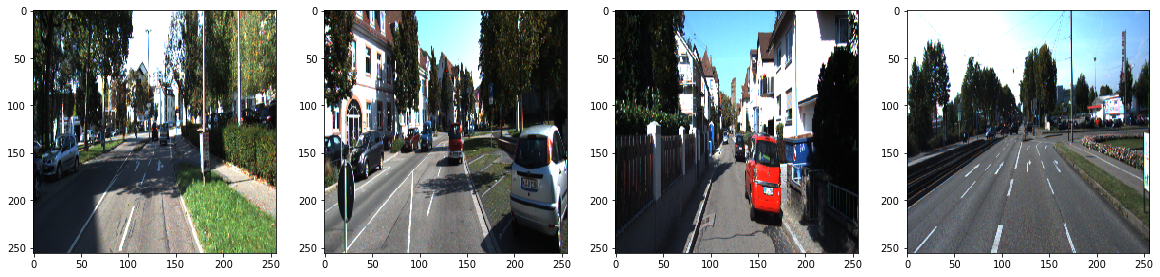

shape of images as tensor	 3 x H x W: 	 torch.Size([3, 256, 256])
shape of labels as tensor	  2 x H x W: 	 torch.Size([2, 256, 256])



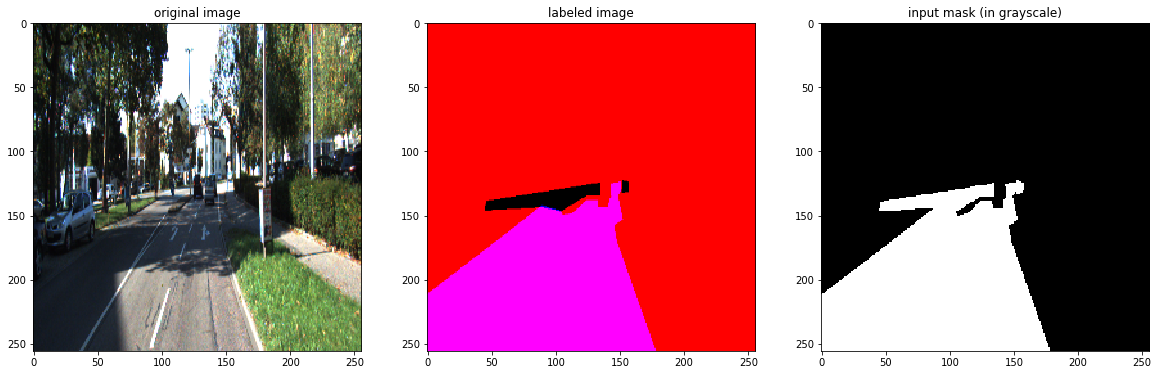

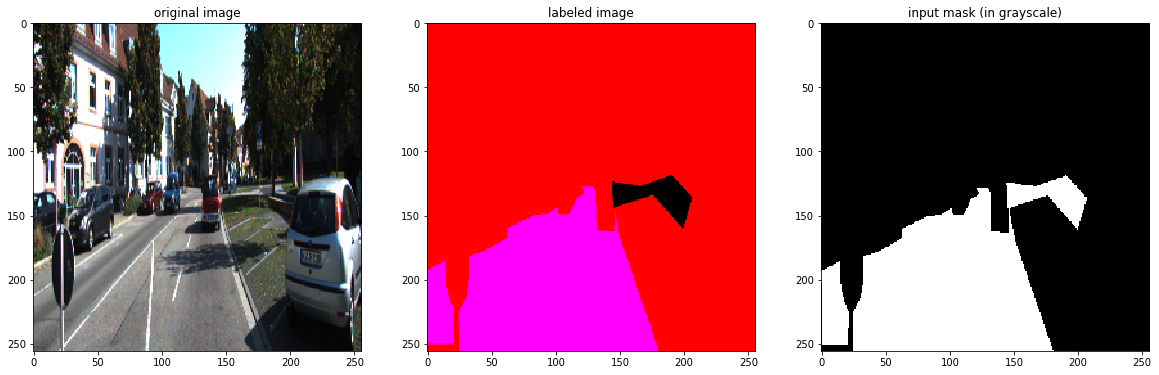

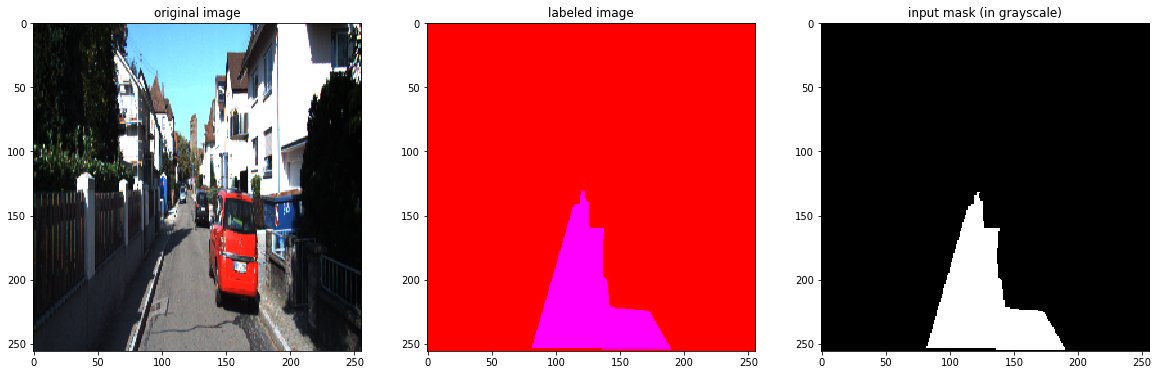

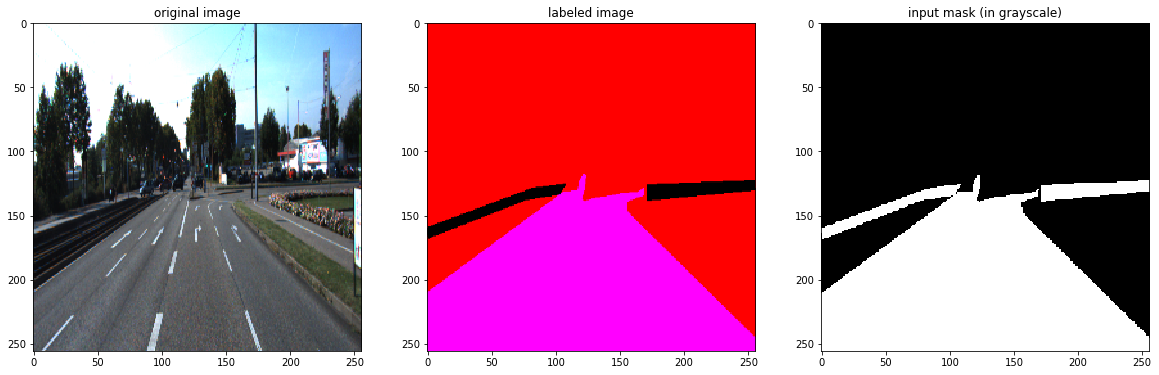


Updated image shape in dataloader W x H : (256, 256)


In [6]:
# Visualize sample data
data_dir = './data'
data_folder = os.path.join(data_dir, 'data_road/training')
image_shape = (256,256)  # H x W ,channel, KITTI dataset uses 160x576 images to resize to 224 minimum
batch_size = 8

# get dataloader
get_batches_fn = gen_batch_function('train', image_shape)

# obtain one batch of training images
images, labels, gt_images = next(get_batches_fn(batch_size))

# current range
img = images[4]
print('image scale: \tMin: ', img.min(), '\tMax: ', img.max())       # image scale from 0. to 1. expected by pretrained model
label = labels[4]
print('label scale: \tMin: ', label.min(), '\tMax: ', label.max())   # label scale from 0. to 255.

# Display sample images
plt.figure(figsize=(20,40))
for i in range(4):
    plt.subplot(1,4,i+1)
    img = np.copy(images[i])
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
plt.show()
print('shape of images as tensor\t 3 x H x W: \t', images[0].shape)
print('shape of labels as tensor\t  2 x H x W: \t', labels[0].shape)
print()

for i in range(4):
    
    plt.figure(figsize=(20,40))
    
    plt.subplot(i+1,3,1)
    img = np.copy(images[i])
    img = np.transpose(img, (1, 2, 0))
    plt.imshow(img)
    plt.title('original image')
    
    plt.subplot(i+1,3,2)
    gt = np.array(gt_images[i], dtype=np.uint8)
    plt.imshow(gt)
    plt.title('labeled image')
    
    plt.subplot(i+1,3,3)
    label = np.transpose(labels[i], (1, 2, 0))
    plt.imshow(label[:,:,1], cmap='gray')
    plt.title('input mask (in grayscale)')
    
    plt.show()

image_shape = (images[0].shape[1],images[0].shape[2]) # update W, H to new values
print('\nUpdated image shape in dataloader W x H :', image_shape)

## Manipulating layers and parameters
- check this out : https://blog.paperspace.com/pytorch-101-advanced/

In [ ]:
vgg = models.vgg16(pretrained=True).features  # without the head of Linear section
print(vgg._modules)
print()
print('layer 0 or input layer: ', vgg._modules['0'])

In [ ]:
vgg = models.vgg16(pretrained=True)
print(vgg._modules['features'])
print()
print('layer 0 or input layer: ', vgg._modules['features'][0])

In [ ]:
print('CHILDREN')
print(list(vgg.children()))
print()
print('MODULES')
print(list(vgg.modules()))
print()
print('NAMED_MODULES')
for x in vgg.named_modules():
    print(x[0], x[1], "\n-------------------------------")
print()
print('NAMED_CHILDREN')
for x in vgg.named_children():
    print(x[0], x[1], "\n-------------------------------")

In [ ]:
vgg = nn.DataParallel(vgg)   # ‘Sequential’ object has no attribute ‘module’.
# The .module attribute will be added by nn.DataParallel for all models including nn.Sequential:
print(vgg.module)

In [ ]:
# print(list(vgg.parameters()))  # will print all model weights

# Model Architecture

In [7]:
class Encoder(nn.Module):
    def __init__(self, vgg_path):
        super(Encoder, self).__init__()
        
        self.vgg_path = vgg_path    
        
        if self.vgg_path != None and os.path.exists(os.path.join(self.vgg_path,'saved_model.pt')):
            vgg.load_state_dict(torch.load('saved_model/saved_model.pt'))
        
        else:
            # define VGG16 model
            self.vgg_path = './data/saved_model'
            self.vgg = models.vgg16(pretrained=True).features # x.features drops the head Linear section, keep the top Conv features section

            for param in self.vgg.parameters():               # freeze parameters of pre-trained VGG16 model
                param.requires_grad = False

        if not os.path.exists(os.path.join(self.vgg_path,'saved_model.pt')):
            try:
                !mkdir -p data/saved_model
                torch.save(self.vgg.state_dict(), 'saved_model.pt')
            except:
                torch.save(self.vgg.state_dict(), 'saved_model.pt')

        if not torch.cuda.is_available():
            summary(self.vgg, (3, 375, 1242))
        else:
            print(self.vgg)
            
        
    def forward(self, images):
        
        # Get the needed layers' outputs for building FCN-VGG16
        vgg_layer3_out_tensor_name = 'layer3_out:0'
        vgg_layer4_out_tensor_name = 'layer4_out:0'
        vgg_layer7_out_tensor_name = 'layer7_out:0'
    
        layers = {'16' : 'MaxPool2d_3_out',
                  '23' : 'MaxPool2d_4_out',
                  '30' : 'MaxPool2d_7_out'}
    
        features = {}
        
        x = images
    
        for index in range(len(self.vgg._modules)):
            layer = self.vgg._modules[str(index)]
            x = layer(x)
            if str(index) in layers.keys():
                features[layers[str(index)]] = x
        
        
        return features['MaxPool2d_3_out'], features['MaxPool2d_4_out'], features['MaxPool2d_7_out']

In [8]:
class Decoder(nn.Module):
    def __init__(self, num_classes=2):
        super(Decoder, self).__init__()
        
        ## Decoder parameters
        self.vgg_layer3_depth = 256
        self.vgg_layer4_depth = 512
        self.vgg_layer7_depth = 512
        self.num_classes = num_classes
        self.height = image_shape[0]
        self.width = image_shape[1]
              
         ## Decoder layers definition
        
        # BUILD the 1x1 CONV SAMPLING AND SKIP CONNECTIONS - Maintain H and W, BRING VOLUME DEPTH IN SYNC WITH DECODER
    
        self.skip_vgg_layer4 = nn.Conv2d(in_channels = self.vgg_layer4_depth, out_channels = 256,
                                         kernel_size = (1,1), stride = 1, padding = 0)
    
        self.skip_vgg_layer3 = nn.Conv2d(in_channels = self.vgg_layer3_depth, out_channels = 128,
                                         kernel_size = (1,1), stride = 1, padding = 0)
    
        # BatchNorm layers
        #self.dropout = nn.Dropout(0.2)
        self.bn1 = nn.BatchNorm2d(256)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(32)
        self.bn5 = nn.BatchNorm2d(16)
        
        # BUILD DECODER
        self.deconv1 = nn.ConvTranspose2d(in_channels= 512, out_channels= 256,
                                                   kernel_size=2, stride=2, padding=0, dilation=1, output_padding=0)
        
        self.deconv2 = nn.ConvTranspose2d(in_channels= 256, out_channels= 128,
                                                   kernel_size=2, stride=2, padding=0, dilation=1, output_padding=0)
    
        self.deconv3 = nn.ConvTranspose2d(in_channels= 128, out_channels= 64,
                                                   kernel_size=2, stride=2, padding=0, dilation=1, output_padding=0)
        
        self.deconv4 = nn.ConvTranspose2d(in_channels= 64, out_channels= 32,
                                                   kernel_size=2, stride=2, padding=0, dilation=1, output_padding=0)
        
        self.deconv5 = nn.ConvTranspose2d(in_channels= 32, out_channels= 16,
                                                   kernel_size=2, stride=2, padding=0, dilation=1, output_padding=0)
        
        self.AMP = nn.AdaptiveMaxPool3d(output_size = (2, self.height, self.width))
        
        
        # Initialize decoder layers using Xavier's initialization
        self.model_init()
        
        # To provide lisibility, print tensor dimensions when instantiating the model
        self.print_tensor_dimensions = True
        
        
    
    def forward(self, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out):
        
        ## Decoder forward useful parameters
        self.batch_size = vgg_layer3_out.shape[0]
        self.height = image_shape[0]
        self.width = image_shape[1]
        self.vgg_layer3_out = vgg_layer3_out
        self.vgg_layer4_out = vgg_layer4_out
        self.vgg_layer7_out = vgg_layer7_out
        
        
        # PASS VGG OUTPUTS THRU 1x1 CONV LAYERS
        
        if self.print_tensor_dimensions: print('F-32 VGG output dimensions in: \t\t\t\t\t', self.vgg_layer7_out.shape)
            
        self.vgg_layer4_logits = self.skip_vgg_layer4(self.vgg_layer4_out)          # 128 x 14 x 14 (for 224x224)
        
        if self.print_tensor_dimensions: print('VGG F-16 skip connection post Conv1x1: \t\t\t\t', self.vgg_layer4_logits.shape)
            
        self.vgg_layer3_logits = self.skip_vgg_layer3(self.vgg_layer3_out)          # 64 x 28 x 28  (for 224x224)
        
        if self.print_tensor_dimensions: print('VGG F-8 skip connection post Conv1x1: \t\t\t\t', self.vgg_layer4_logits.shape)
            
       
        # FEED FORWARD DECODER
        
        # Upsampling H,W by 2
        x = F.relu_(self.deconv1( self.vgg_layer7_out))
        if self.print_tensor_dimensions: print('Dimensions of Decoder upsampling output deconv1 : \t\t', x.shape)
        
        # Skip connection
        x = self.bn1(x.add(self.vgg_layer4_logits))                                     
        if self.print_tensor_dimensions: print('Dimensions of Decoder upsampling deconv1 + skip FCN-16 : \t', x.shape)
        
        # Upsampling H,W by 2
        x = F.relu_(self.deconv2(x))                    
        if self.print_tensor_dimensions: print('Dimensions of Decoder upsampling output deconv2 : \t\t', x.shape)
            
        # Skip connection
        x = self.bn2(x.add(self.vgg_layer3_logits))                                     
        if self.print_tensor_dimensions: print('Dimensions of Decoder upsampling deconv2 + skip FCN-8 : \t', x.shape)
        
        # Upsampling H,W by 8
        x = self.bn3(F.relu_(self.deconv3(x)))                        
        if self.print_tensor_dimensions: print('Dimensions of upsampling output deconv3 : \t\t\t', x.shape)
            
        # Upsampling H,W by 16
        x = self.bn4(F.relu_(self.deconv4(x)))
        if self.print_tensor_dimensions: print('Dimensions of upsampling output deconv4 : \t\t\t', x.shape)
        
        # Upsampling H,W by 32
        x = self.bn5(F.relu_(self.deconv5(x)))
       
        if self.print_tensor_dimensions: print('Dimensions of upsampling output deconv5 : \t\t\t', x.shape)
        
        # Bring feature depth to num_classes
        output = self.AMP(x)
        
        # We ensure appropriate Tensor shape:  batchsize x num_classes x H x W
        output = output.view(self.batch_size,self.num_classes, self.height, self.width)  
        if self.print_tensor_dimensions: print('Prediction AMP output dimensions: \t\t\t\t', output.shape)
        
        # Turn off printing dimensions after instantiation
        self.print_tensor_dimensions = False
        
        return output
    
    
    
    def model_init(self):
        # We initialize the decoder parameters using Xavier's approach
        torch.nn.init.xavier_uniform_(self.deconv1.weight)
        torch.nn.init.xavier_uniform_(self.deconv2.weight)
        torch.nn.init.xavier_uniform_(self.deconv3.weight)
        torch.nn.init.xavier_uniform_(self.deconv4.weight)
        torch.nn.init.xavier_uniform_(self.deconv5.weight)
        pass

In [9]:
# Instantiate the models

num_classes = 2

encoder = Encoder(None)

decoder = Decoder(num_classes)

# Move models to GPU if CUDA is available. 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder.to(device)
decoder.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(

Decoder(
  (skip_vgg_layer4): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
  (skip_vgg_layer3): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv1): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
  (deconv2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (deconv3): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (deconv4): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (deconv5): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (AMP): AdaptiveMaxPool3d(output

In [10]:
def count_parameters(model):
    return np.sum(p.numel() for p in model.parameters() if p.requires_grad)

print('total number of trainable parameters for encoder [%d] and decoder [%d]'
      %(count_parameters(encoder), count_parameters(decoder)))

total number of trainable parameters for encoder [0] and decoder [864080]


In [11]:
# Define the loss function.
#criterion = nn.CrossEntropyLoss(ignore_index=255).cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss(ignore_index=255) # combines a softmax
criterion = nn.BCELoss().cuda() if torch.cuda.is_available() else nn.BCELoss()

# Specify the learnable parameters of the model.
params = list(decoder.parameters())
    
# Define the optimizer.
optimizer = optim.Adam(params, lr=0.001, betas=(0.9,0.999), eps=1e-08)
#optimizer = optim.SGD(params, lr=0.001, momentum=0.9, weight_decay=5e-04)

In [12]:
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

Tesla K80


In [13]:
num_classes = 2
#image_shape = (375,1242) modified to (352, 1216) # H x W, KITTI dataset used 160x576 images # Updated by dataloader transform
data_dir = './data'

num_epochs = 40
batch_size = 32
print_every = 10
save_every = 10

In [14]:
data_folder = os.path.join(data_dir, 'data_road/training')
image_paths = glob(os.path.join(data_folder, 'image_2', '*.png'))
num_train = len(image_paths)
print('Number of training images: ', len(image_paths))

Number of training images:  289


In [15]:
# Set the total number of training steps per epoch.
total_step = math.ceil(num_train / batch_size)
print('number of training steps per batch: ', total_step)

number of training steps per batch:  10


In [ ]:
# Download pretrained vgg model
helper.maybe_download_pretrained_vgg(data_dir)

# OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
# You'll need a GPU with at least 10 teraFLOPS to train on.
#  https://www.cityscapes-dataset.com/

In [16]:
# Get dataloader
# Create function to get batches
get_batches_fn_train = gen_batch_function('train', image_shape)

# OPTIONAL: Augment Images for better results
#  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

In [17]:
# LOAD AND RESUME MODEL TRAINING
## load the best saved model parameters (by your path name)

encoder.load_state_dict(torch.load('seg_saved_models/encoder-AMP-180.pkl'))
decoder.load_state_dict(torch.load('seg_saved_models/decoder-AMP-180.pkl'))


In [174]:
decoder.train()

Decoder(
  (skip_vgg_layer4): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
  (skip_vgg_layer3): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1))
  (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv1): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
  (deconv2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (deconv3): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(2, 2))
  (deconv4): ConvTranspose2d(64, 32, kernel_size=(2, 2), stride=(2, 2))
  (deconv5): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
  (AMP): AdaptiveMaxPool3d(output

In [17]:
import torch.utils.data as data
import requests
import time
from workspace_utils import active_session

old_time = time.time()

with active_session():
    
    start_time = time.time()
    
    for epoch in range(140, 140+num_epochs+1):
        
        previous_time = time.time()

        for i_step in range(1, total_step+1):

            # Obtain the batch.
            images, labels, _ = next(iter(get_batches_fn_train(batch_size)))
            

            # Move batch of images and captions to GPU if CUDA is available.
            images = images.to(device)
            labels = labels.to(device)  # batch_size x H x W  (road = 1, background = 255 ignored by loss function => 0)
            
            # Zero the gradients.
            decoder.zero_grad()
            encoder.zero_grad()

            # Pass the inputs through the CNN-RNN model.
            vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = encoder(images)
            outputs = decoder(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out) # batch_size x num_classes x H x W
            
            outputs = torch.sigmoid(outputs)
            
            # Calculate the batch loss.
            loss = criterion(outputs, labels)

            # resize into a vector representing ground truth - 1 or 0 (255) - for each pixel
            #labels = labels.view(batch_size, image_shape[1]*image_shape[0])   
            
            # For multi-class classification, CrossEntropyLoss takes :
            # - output with probabilities per class (batch x num_class x HW)
            # - target with indice of the true value per pixel ie (batch x HW)
    
            # CrossEntropyLoss MUST take output as float, target as Longtensor(int). (use variableX.dtype to check unit type)
            #loss = criterion(predictions.float(), labels.long())
            
            # Backward pass.
            loss.backward()

            # Update the parameters in the optimizer.
            optimizer.step()

            # Get training statistics.
            current_time = time.time()
            stats = 'Epoch [%d/%d], Step [%d/%d],\t Loss: %.4f,\t execution_time: %d sec\t training_time:\t %d hr %d min' % (epoch, num_epochs, i_step, total_step, loss.item(),
                    (current_time - previous_time), (current_time-start_time)//3600, (current_time-start_time)//60-((current_time-start_time)//3600)*60)
            
            # Print training statistics (on same line).
            print('\r' + stats, end="")
            sys.stdout.flush()

            # Print training statistics (on different line).
            if i_step % print_every == 0:
                print('\r' + stats)

        # Save the weights.
        if epoch % save_every == 0:
            torch.save(decoder.state_dict(), os.path.join('./seg_saved_models', 'decoder-AMP-%d.pkl' % epoch))
            torch.save(encoder.state_dict(), os.path.join('./seg_saved_models', 'encoder-AMP-%d.pkl' % epoch))


F-32 VGG output dimensions in: 					 torch.Size([32, 512, 8, 8])
VGG F-16 skip connection post Conv1x1: 				 torch.Size([32, 256, 16, 16])
VGG F-8 skip connection post Conv1x1: 				 torch.Size([32, 256, 16, 16])
Dimensions of Decoder upsampling output deconv1 : 		 torch.Size([32, 256, 16, 16])
Dimensions of Decoder upsampling deconv1 + skip FCN-16 : 	 torch.Size([32, 256, 16, 16])
Dimensions of Decoder upsampling output deconv2 : 		 torch.Size([32, 128, 32, 32])
Dimensions of Decoder upsampling deconv2 + skip FCN-8 : 	 torch.Size([32, 128, 32, 32])
Dimensions of upsampling output deconv3 : 			 torch.Size([32, 64, 64, 64])
Dimensions of upsampling output deconv4 : 			 torch.Size([32, 32, 128, 128])
Dimensions of upsampling output deconv5 : 				 torch.Size([32, 16, 256, 256])
Prediction AMP output dimensions: 			 torch.Size([32, 2, 256, 256])
Epoch [140/180], Step [10/10],	 Loss: 0.1461,	 execution_time: 31 sec	 training_time:	 0 hr 0 min
Epoch [141/180], Step [10/10],	 Loss: 0.1356,	 ex

In [ ]:
 # TODO: Save inference data using helper.save_inference_samples
        #  helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)

        # OPTIONAL: Apply the trained model to a video
    

# INFERENCE

In [18]:
# Create function to get batches
get_batches_fn_test = gen_batch_function('test', image_shape)

In [19]:
def get_test_paths(test_path):
    test_paths = [os.path.basename(path) for path in glob(os.path.join(test_path, '*.png'))]
    return test_paths

In [20]:
def resize_label(image_path, label):
    image = io.imread(image_path)
    label = transform.resize(label, image.shape)
    output = cv2.addWeighted(image, 0.6, label, 0.4, 0, dtype = 0)
    return output

F-32 VGG output dimensions in: 					 torch.Size([4, 512, 8, 8])
VGG F-16 skip connection post Conv1x1: 				 torch.Size([4, 256, 16, 16])
VGG F-8 skip connection post Conv1x1: 				 torch.Size([4, 256, 16, 16])
Dimensions of Decoder upsampling output deconv1 : 		 torch.Size([4, 256, 16, 16])
Dimensions of Decoder upsampling deconv1 + skip FCN-16 : 	 torch.Size([4, 256, 16, 16])
Dimensions of Decoder upsampling output deconv2 : 		 torch.Size([4, 128, 32, 32])
Dimensions of Decoder upsampling deconv2 + skip FCN-8 : 	 torch.Size([4, 128, 32, 32])
Dimensions of upsampling output deconv3 : 			 torch.Size([4, 64, 64, 64])
Dimensions of upsampling output deconv4 : 			 torch.Size([4, 32, 128, 128])
Dimensions of upsampling output deconv5 : 			 torch.Size([4, 16, 256, 256])
Prediction AMP output dimensions: 				 torch.Size([4, 2, 256, 256])


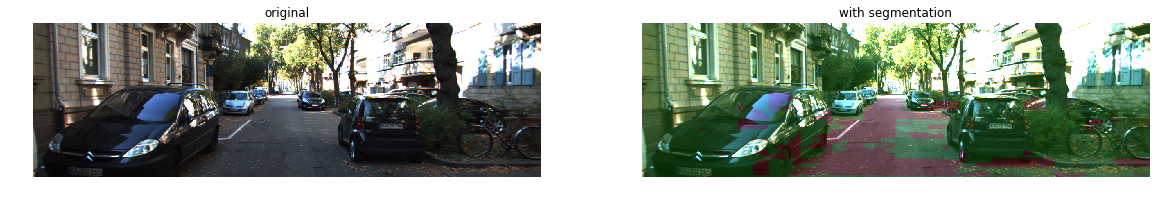

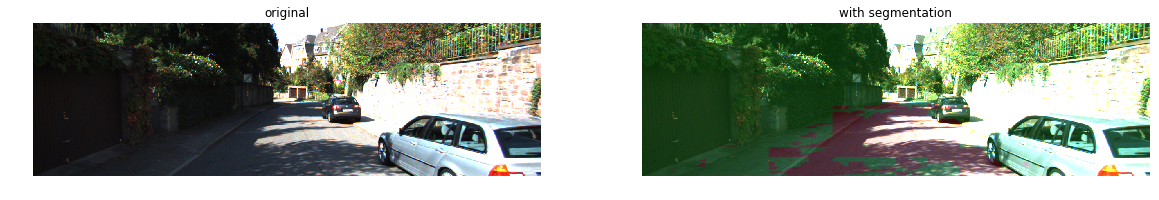

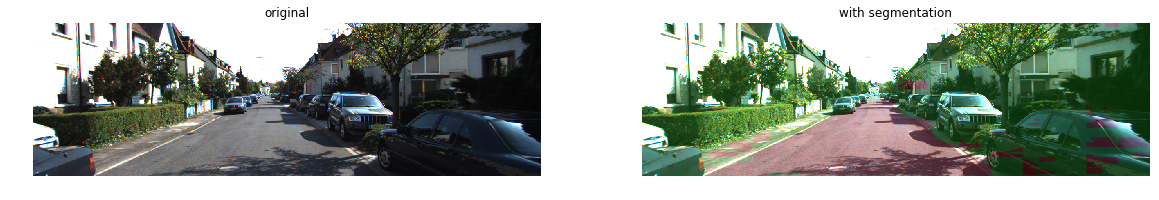

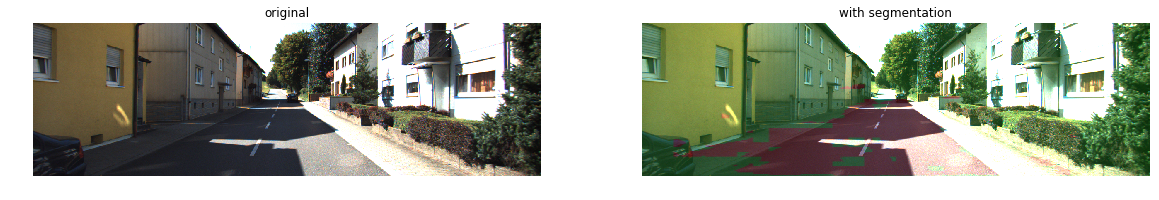

In [21]:
# Visualize sample data
decoder.eval()
# obtain one batch of training images
images, image_paths = next(get_batches_fn_test(4))

images = images.to(device)
            
with torch.no_grad():
    
    # Pass the inputs through the FCN model.
    vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = encoder(images)
    outputs = decoder(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out) # batch_size x num_classes x H x W
    outputs = torch.sigmoid(outputs)
    
    for index, output in enumerate(outputs):
        
        # Get the predictions
        pred = output.detach().cpu().numpy()                         # 2 x H x W
        pred = pred.transpose((1, 2, 0))                             # H x W x 2
        pred = pred.argmax(axis=2)
        pred = (pred > 0.5)                                          # retain pixels coming from channel 1 not channel 0 (ind=0)

        # Prepare 3D mask with road detected in light red (channel1), non-road in light green (channel2)
        pred = pred.reshape(*pred.shape, 1)                                      # H x W x 1  True = road, False otherwise
        pred = np.concatenate((pred, np.invert(pred)), axis=2).astype('float')   # H x W x 2  inverse on channel 2
        pred = np.concatenate((pred, np.zeros((*pred[:,:,0].shape, 1))), axis=2).astype('float')  # H x W x 3 channel3 with zeros
        
        # Channel1 road = 127, 0 elsewhere; channel2 Non-road=127, 0 elsewhere, Channel3 only 0s
        pred[pred == 1.0] = 127.0   

        # Combine mask with image
        img = io.imread(image_paths[index])
        pred = cv2.resize(pred, (img.shape[1],img.shape[0]))
        img = np.array(img, dtype='uint8')
        
        
        # Merge original image with mask
        street = cv2.addWeighted(img, 0.6, pred, 0.15, 0, dtype = 0)
        street = street/127.0
        street = np.clip(street, 0.0, 1.0)                               # required imshow format: ndarray of integers
        
        # Display
        plt.figure(figsize=(20,40))
        plt.subplot(1,2,1)
        plt.imshow(img)
        plt.title('original')
        plt.axis('off')
        plt.subplot(1,2,2)
        plt.imshow(street)
        plt.title('with segmentation')
        plt.axis('off')
        plt.show()

# FOR VIDEO CLIP

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
street_output = 'test_videos_output/urban.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/urban.mp4')
street_clip = clip2.fl_image(process_image)
%time street_clip.write_videofile(street_output, audio=False)

In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

NameError: name 'HTML' is not defined

# FOR GIF

In [22]:
import matplotlib
directory = './test_videos_output/urban4'

In [23]:
# Create function to get batches
image_shape = (256,256)

In [24]:
image_paths = glob(os.path.join('data', 'urban4', '*.png'))
transform_img = transforms.Compose([transforms.ToTensor()])

for i, image_path in enumerate(sorted(image_paths)):
    
    # Attention cv2 format is H, W and BGR not RGB
    image = io.imread(image_path)
    image = np.asarray(image)        ### Numpy so format now H, W, 3 - data ndarray type
    
    # Re-size to image_shape target : image of target shape H x W x 3 - label is H x W target shape
    # Attention: cv2 takes in inversed tuple shape W x H
    img = cv2.resize(image, (image_shape[1], image_shape[0]))
                
    # Convert to tensor
    img = transform_img(img)               ### Tensor shape 3 x H x W as expected by pretrained models
                
    img = img.to(device)
            
    with torch.no_grad():
    
    # Pass the inputs through the FCN model.
        vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = encoder(img.unsqueeze(0))
        output = decoder(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out) # batch_size x num_classes x H x W
        output = torch.sigmoid(output)
        
        # Get the predictions
        pred = output.squeeze().detach().cpu().numpy()               # 2 x H x W
        pred = pred.transpose((1, 2, 0))                             # H x W x 2
        pred = pred.argmax(axis=2)
        pred = (pred > 0.5)                                          # retain pixels coming from channel 1 not channel 0 (ind=0)
        pred = pred.astype('uint8')
        pred = cv2.resize(pred, (image.shape[1],image.shape[0]))     # Resize to test image original format
        
        # Prepare mask with road detected in light green
        segmentation = pred.reshape(*pred.shape, 1)      
        mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
        mask = scipy.misc.toimage(mask, mode="RGBA")
        
        
        street = scipy.misc.toimage(image)
        street.paste(mask, box=None, mask=mask)
        street = np.array(street)
        
        matplotlib.image.imsave(os.path.join(directory,image_path.split('/')[-1]), street)
        print('processed....{}/{}'.format(i+1, len(image_paths)), os.path.join(directory,image_path.split('/')[-1]))


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:37: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.


processed....1/426 ./test_videos_output/urban4/0000000000.png
processed....2/426 ./test_videos_output/urban4/0000000001.png
processed....3/426 ./test_videos_output/urban4/0000000002.png
processed....4/426 ./test_videos_output/urban4/0000000003.png
processed....5/426 ./test_videos_output/urban4/0000000004.png
processed....6/426 ./test_videos_output/urban4/0000000005.png
processed....7/426 ./test_videos_output/urban4/0000000006.png
processed....8/426 ./test_videos_output/urban4/0000000007.png
processed....9/426 ./test_videos_output/urban4/0000000008.png
processed....10/426 ./test_videos_output/urban4/0000000009.png
processed....11/426 ./test_videos_output/urban4/0000000010.png
processed....12/426 ./test_videos_output/urban4/0000000011.png
processed....13/426 ./test_videos_output/urban4/0000000012.png
processed....14/426 ./test_videos_output/urban4/0000000013.png
processed....15/426 ./test_videos_output/urban4/0000000014.png
processed....16/426 ./test_videos_output/urban4/0000000015.png
p

processed....131/426 ./test_videos_output/urban4/0000000130.png
processed....132/426 ./test_videos_output/urban4/0000000131.png
processed....133/426 ./test_videos_output/urban4/0000000132.png
processed....134/426 ./test_videos_output/urban4/0000000133.png
processed....135/426 ./test_videos_output/urban4/0000000134.png
processed....136/426 ./test_videos_output/urban4/0000000135.png
processed....137/426 ./test_videos_output/urban4/0000000136.png
processed....138/426 ./test_videos_output/urban4/0000000137.png
processed....139/426 ./test_videos_output/urban4/0000000138.png
processed....140/426 ./test_videos_output/urban4/0000000139.png
processed....141/426 ./test_videos_output/urban4/0000000140.png
processed....142/426 ./test_videos_output/urban4/0000000141.png
processed....143/426 ./test_videos_output/urban4/0000000142.png
processed....144/426 ./test_videos_output/urban4/0000000143.png
processed....145/426 ./test_videos_output/urban4/0000000144.png
processed....146/426 ./test_videos_outpu

processed....260/426 ./test_videos_output/urban4/0000000259.png
processed....261/426 ./test_videos_output/urban4/0000000260.png
processed....262/426 ./test_videos_output/urban4/0000000261.png
processed....263/426 ./test_videos_output/urban4/0000000262.png
processed....264/426 ./test_videos_output/urban4/0000000263.png
processed....265/426 ./test_videos_output/urban4/0000000264.png
processed....266/426 ./test_videos_output/urban4/0000000265.png
processed....267/426 ./test_videos_output/urban4/0000000266.png
processed....268/426 ./test_videos_output/urban4/0000000267.png
processed....269/426 ./test_videos_output/urban4/0000000268.png
processed....270/426 ./test_videos_output/urban4/0000000269.png
processed....271/426 ./test_videos_output/urban4/0000000270.png
processed....272/426 ./test_videos_output/urban4/0000000271.png
processed....273/426 ./test_videos_output/urban4/0000000272.png
processed....274/426 ./test_videos_output/urban4/0000000273.png
processed....275/426 ./test_videos_outpu

processed....389/426 ./test_videos_output/urban4/0000000388.png
processed....390/426 ./test_videos_output/urban4/0000000389.png
processed....391/426 ./test_videos_output/urban4/0000000390.png
processed....392/426 ./test_videos_output/urban4/0000000391.png
processed....393/426 ./test_videos_output/urban4/0000000392.png
processed....394/426 ./test_videos_output/urban4/0000000393.png
processed....395/426 ./test_videos_output/urban4/0000000394.png
processed....396/426 ./test_videos_output/urban4/0000000395.png
processed....397/426 ./test_videos_output/urban4/0000000396.png
processed....398/426 ./test_videos_output/urban4/0000000397.png
processed....399/426 ./test_videos_output/urban4/0000000398.png
processed....400/426 ./test_videos_output/urban4/0000000399.png
processed....401/426 ./test_videos_output/urban4/0000000400.png
processed....402/426 ./test_videos_output/urban4/0000000401.png
processed....403/426 ./test_videos_output/urban4/0000000402.png
processed....404/426 ./test_videos_outpu

In [25]:
image_paths = glob(os.path.join('test_videos_output/urban4', '*.png'))
print(len(image_paths))
for image_path in sorted(image_paths):
    img = io.imread(image_path)
    #plt.imshow(img)
    #plt.show()

426


In [26]:
import matplotlib
directory = './test_videos_output/urban3'

In [24]:
image_paths = glob(os.path.join('data', 'urban3', '*.png'))
transform_img = transforms.Compose([transforms.ToTensor()])
i=0
for image_path in sorted(image_paths):
    
    # Attention cv2 format is H, W and BGR not RGB
    image = io.imread(image_path)
    image = np.asarray(image)        ### Numpy so format now H, W, 3 - data ndarray type
    
    # Re-size to image_shape target : image of target shape H x W x 3 - label is H x W target shape
    # Attention: cv2 takes in inversed tuple shape W x H
    img = cv2.resize(image, (image_shape[1], image_shape[0]))
                
    # Convert to tensor
    img = transform_img(img)               ### Tensor shape 3 x H x W as expected by pretrained models
                
    img = img.to(device)
            
    with torch.no_grad():
    
    # Pass the inputs through the FCN model.
        vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = encoder(img.unsqueeze(0))
        output = decoder(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out) # batch_size x num_classes x H x W
        output = torch.sigmoid(output)
        
        # Get the predictions
        pred = output.squeeze().detach().cpu().numpy()               # 2 x H x W
        pred = pred.transpose((1, 2, 0))                             # H x W x 2
        pred = pred.argmax(axis=2)
        pred = (pred > 0.5)                                          # retain pixels coming from channel 1 not channel 0 (ind=0)
        
        # Prepare 3D mask with road detected in light red (channel1), non-road in light green (channel2)
        pred = pred.reshape(*pred.shape, 1)                                      # H x W x 1  True = road, False otherwise
        pred = np.concatenate((pred, np.invert(pred)), axis=2).astype('float')   # H x W x 2  inverse on channel 2
        pred = np.concatenate((pred, np.zeros((*pred[:,:,0].shape, 1))), axis=2).astype('float')  # H x W x 3 channel3 with zeros
        pred = cv2.resize(pred, (image.shape[1],image.shape[0]))
        
        
        # Channel1 road = 127, 0 elsewhere; channel2 Non-road=127, 0 elsewhere, Channel3 only 0s
        pred[pred == 1.0] = 127.0

        # Combine mask with image
        img = np.copy(image)
        
        img = np.array(img, dtype='uint8')
        
        street = cv2.addWeighted(img, 0.8, pred, 0.15, 0, dtype = 0)      # Merge original image with mask
        
        street = street/127.0
        street = np.clip(street, 0.0, 1.0)                               # required imshow format: ndarray of integers
        i+=1
        
        #street = np.array(street)
        
        matplotlib.image.imsave(os.path.join(directory,image_path.split('/')[-1]), street)
        print('processed....{}/{}'.format(i, len(image_paths)), os.path.join(directory,image_path.split('/')[-1]))
       
       

processed....1/82 ./test_videos_output/urban3/0000000000.png
processed....2/82 ./test_videos_output/urban3/0000000001.png
processed....3/82 ./test_videos_output/urban3/0000000002.png
processed....4/82 ./test_videos_output/urban3/0000000003.png
processed....5/82 ./test_videos_output/urban3/0000000004.png
processed....6/82 ./test_videos_output/urban3/0000000005.png
processed....7/82 ./test_videos_output/urban3/0000000006.png
processed....8/82 ./test_videos_output/urban3/0000000007.png
processed....9/82 ./test_videos_output/urban3/0000000008.png
processed....10/82 ./test_videos_output/urban3/0000000009.png
processed....11/82 ./test_videos_output/urban3/0000000010.png
processed....12/82 ./test_videos_output/urban3/0000000011.png
processed....13/82 ./test_videos_output/urban3/0000000012.png
processed....14/82 ./test_videos_output/urban3/0000000013.png
processed....15/82 ./test_videos_output/urban3/0000000014.png
processed....16/82 ./test_videos_output/urban3/0000000015.png
processed....17/8

In [30]:
def gen_batch_function_video_mode(image_shape = (352,1216)):
    
    transform_img = transforms.Compose([transforms.ToTensor()])

    def get_batches_fn(batch_size):
        
        # Grab image and label paths
        image_paths = glob(os.path.join('data', 'street', '*.png'))
        
        # Loop through batches and grab images, yielding each batch
        for batch_i in range(0, len(image_paths), batch_size):
            
            images = torch.zeros([batch_size,3, image_shape[0], image_shape[1]])
        
            for index, image_file in enumerate(image_paths[batch_i:batch_i+batch_size]):
                
                # Load image  Attention: PIL image format W,H and Image type (not numpy)
                # Attention cv2 format is H, W and BGR not RGB
                image = cv2.imread(image_file)
                image = np.asarray(image)        ### Numpy so format now H, W, 3 - data ndarray type
                
            
                # Re-size to image_shape target : image of target shape H x W x 3 - label is H x W target shape
                # Attention: cv2 takes in inversed tuple shape W x H
                image = cv2.resize(image, (image_shape[1], image_shape[0]))
                
                # Convert to tensor
                image = transform_img(image)               ### Tensor shape 3 x H x W as expected by pretrained models
                
                # store images and labels in array
                images[index,:,:,:] = image
                

                yield images, image_paths[batch_i:batch_i+batch_size]
            
    return get_batches_fn